## Instalação de pacotes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/path/input_file_name.zip" -d "/content/drive/path/output_folder/"

unzip:  cannot find or open /content/drive/path/input_file_name.zip, /content/drive/path/input_file_name.zip.zip or /content/drive/path/input_file_name.zip.ZIP.


In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-6x94dwor
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-6x94dwor
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20046 sha256=5049e1920c5186a54c344fd9eda651bc1b3dc4fc3443c2caca4d0f58215a0281
  Stored in directory: /tmp/pip-ephem-wheel-cache-a4tgs3c7/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install Keras-Applications

## Import de bibliotecas e definição da função

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from glob import glob # Navegar sobre repositórios
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
from sys import stdout
from classification_models.models.resnet import ResNet18, preprocess_input
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, GlobalAvgPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
import keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




# Definir o caminho onde o dataset se encontra
base_path = '/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB'



def images2matrix(folder, shape):
  """
  A função...
  """
  print(folder, len(os.listdir(folder)))
  data = np.zeros(shape[0] * shape[1] * shape[2],)
  for im_name in os.listdir(folder):
      imr = cv2.imread(folder + '/' + im_name)
      if imr is None:
        print(im_name)
        continue
      resz = cv2.resize(imr, shape[:2], interpolation = cv2.INTER_AREA)   
      data = np.vstack([data, resz.flatten()])

  return data

img_width, img_height = 64, 64
img_shape = (img_width, img_height, 3) # Original -> img_width, img_height = 360, 363

## Separação das classes rotuladas

In [ ]:
images_basophil = images2matrix(base_path + "/basophil", img_shape)
images_eosinophil = images2matrix(base_path + "/eosinophil", img_shape)
images_erythroblast = images2matrix(base_path + "/erythroblast", img_shape)
images_ig = images2matrix(base_path + "/ig", img_shape)
images_lymphocyte = images2matrix(base_path + "/lymphocyte", img_shape)
images_monocyte = images2matrix(base_path + "/monocyte", img_shape)
images_neutrophil = images2matrix(base_path + "/neutrophil", img_shape)
images_neutrophil = images2matrix(base_path + "/neutrophil", img_shape)
images_platelet = images2matrix(base_path + "/platelet", img_shape)

/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/basophil 1218
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/eosinophil 3117
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/erythroblast 1551
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/ig 2895
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/lymphocyte 1214
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/monocyte 1420
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/neutrophil 3329
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/neutrophil 3329
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/platelet 2348


In [ ]:
list_img = [images_basophil, images_eosinophil, images_erythroblast, images_ig, images_lymphocyte, images_monocyte, images_neutrophil, images_platelet]
images = np.concatenate(list_img, axis=0)

In [ ]:
labels = np.array(
    [0]*len(images_basophil) + 
    [1]*len(images_eosinophil) + 
    [2]*len(images_erythroblast) + 
    [3]*len(images_ig) + 
    [4]*len(images_lymphocyte) + 
    [5]*len(images_monocyte) + 
    [6]*len(images_neutrophil) + 
    [7]*len(images_platelet)
)

In [ ]:
lista_labels = ["basophil", "eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]

In [ ]:
n_amostras = len(lista_labels)

## Divisão de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_train = X_train.reshape((-1, *img_shape))/255
X_test = X_test.reshape((-1, *img_shape))/255

In [ ]:
X_train.shape

(11970, 64, 64, 3)

## Treino da ResNet

In [ ]:
base_model = ResNet18(input_shape=img_shape, include_top=False, weights="imagenet", backend=K, layers=tf.keras.layers, models=tf.keras.models, utils=tf.keras.utils)
X = GlobalAvgPool2D(name="Global")(base_model.output) # A saída da ResNet com inclus_top=False é uma imagem, GAP2D vai calcular a media por cada canal
output = Dense(n_amostras, activation = "softmax")(X) # Faz a classificação

model = Model(inputs=base_model.inputs, outputs=[output])
model.summary() # Faz a tabela

list_callbacks = [
  EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=list_callbacks) 

44933120/44920640 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 64, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                           

In [ ]:
model_ResNet = Model(inputs=model.inputs, outputs=[model.get_layer("Global").output])
model_ResNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 64, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                            

In [ ]:
X_train_ResNet = model_ResNet.predict(X_train)
X_test_ResNet = model_ResNet.predict(X_test)

In [ ]:
X_test_ResNet.shape, X_test.shape

((5130, 512), (5130, 64, 64, 3))

In [ ]:
X_test_ResNet[0]

array([1.03326179e-01, 2.71687555e+00, 6.16685629e-01, 1.58949383e-02,
       2.71566153e+00, 6.59821630e-01, 1.70612109e+00, 9.93975177e-02,
       0.00000000e+00, 9.32071567e-01, 0.00000000e+00, 4.82969970e-01,
       2.11853123e+00, 4.63656187e-01, 1.19328952e+00, 9.02239799e-01,
       7.65262023e-02, 1.48124957e+00, 2.05597711e+00, 0.00000000e+00,
       5.34984827e-01, 1.40860543e-01, 1.49581283e-01, 4.60435003e-01,
       1.10686731e+00, 1.49160314e+00, 1.28091797e-01, 1.91282153e+00,
       2.20863461e+00, 4.60445940e-01, 2.86936164e+00, 1.35576323e-04,
       0.00000000e+00, 0.00000000e+00, 1.08414054e+00, 5.23706675e-01,
       1.81486353e-01, 0.00000000e+00, 9.76858199e-01, 9.61122394e-01,
       1.08677256e+00, 1.20091867e-02, 6.21971488e-01, 4.96936232e-01,
       1.41734409e+00, 1.44996345e+00, 0.00000000e+00, 2.51347106e-02,
       9.89986360e-01, 8.73226643e-01, 5.57206154e-01, 3.57183307e-01,
       0.00000000e+00, 2.40985136e-02, 1.51543438e-01, 3.13496619e-01,
      

In [ ]:
y_test.shape

(5130,)

In [ ]:
# Adicionei isso 16/08
print("\nAcurácia: ", accuracy_score(y_test, X_test_ResNet[0]),
      "\nPrecisão: ", precision_score(y_test, X_test_ResNet[0], average="macro"),
      "\nRecall: ", recall_score(y_test, X_test_ResNet[0], average="macro"),
      "\nF1 Score: ", f1_score(y_test, X_test_ResNet[0], average="macro"),
      )

ValueError: ignored

## Aplicação do SVM nas características extraídas pela ResNet18

In [ ]:
clf = SVC(C=10) # Aqui é aplicado o OvR por padrão
clf.fit(X_train_ResNet, y_train)
y_pred = clf.predict(X_test_ResNet)

## Métricas de avaliação

In [ ]:
y_pred.shape

(5130,)

In [ ]:
print("\nAcurácia: ", accuracy_score(y_test, y_pred),
      "\nPrecisão: ", precision_score(y_test, y_pred, average="macro"),
      "\nRecall: ", recall_score(y_test, y_pred, average="macro"),
      "\nF1 Score: ", f1_score(y_test, y_pred, average="macro"),
      )


Acurácia:  0.9729044834307993 
Precisão:  0.9711629400082011 
Recall:  0.9691220109511918 
F1 Score:  0.9700422322032468


In [ ]:
lista_labels_pt = ["basófilo", "eosinófilo", "eritoblasto", "granulóc. imat.", "linfócito", "monócito", "neutrófilo", "plaqueta"]

Text(187.30000000000013, 0.5, 'Classe real')

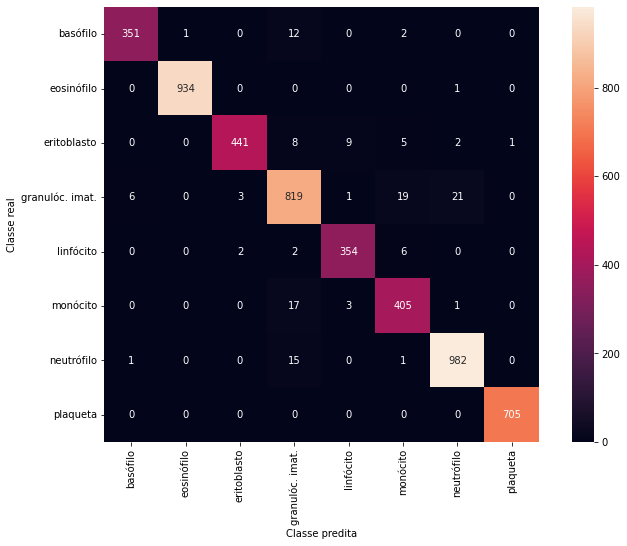

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))
ax = sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), # linhas = true label; colunas = predicted label
                 xticklabels=lista_labels_pt, yticklabels=lista_labels_pt, fmt="d", annot=True, square=True)
ax.set_xlabel("Classe predita")
ax.set_ylabel("Classe real")

Text(187.30000000000013, 0.5, 'Classe real')

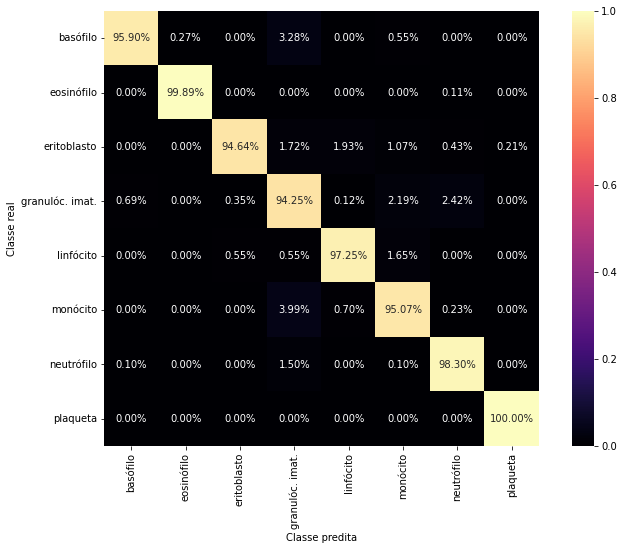

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))
ax = sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred, normalize="true"), # linhas = true label; colunas = predicted label
                 xticklabels=lista_labels_pt, yticklabels=lista_labels_pt, annot=True, square=True, fmt=".2%", cmap="magma")
ax.set_xlabel("Classe predita")
ax.set_ylabel("Classe real")

## Verificar se o modelo está com alta variância ou alto viés

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()